### Import Libery

In [4]:
str = 'Helloworld!!' # l = 12
class unit():
    def __init__(self, left, right):
        self.left = left
        self.right = right
    def printt(self):
        if type(self.left) == unit:
            self.left.printt()
        else:
            print(f'{self.left['symbol']}, ')
            
        if type(self.right) == unit:
            self.right.printt()
        else:
            print(f'{self.right['symbol']}, ')
            


    




In [1]:
from vector_quantize_pytorch.vector_quantize_pytorch import VectorQuantize
from vector_quantize_pytorch.residual_vq import ResidualVQ, MultiLayerVQ

from compressai.models.utils import conv, deconv, update_registered_buffers
from compressai.layers import GDN
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import warnings
import numpy as np
from matplotlib import pyplot as plt
from compressai.models import ScaleHyperprior
from compressai.entropy_models import EntropyBottleneck, GaussianConditional
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"

from torch import Tensor

from typing import Any, Callable, List, Optional, Tuple, Union

from torch.utils.data import DataLoader
from torchvision import transforms
from compressai.datasets import ImageFolder
import torch.optim as optim
import shutil
from pytorch_msssim import ms_ssim

from torchvision import transforms

from compressai.layers import (
    AttentionBlock,
    ResidualBlock,
    ResidualBlockUpsample,
    ResidualBlockWithStride,
    conv3x3,
    subpel_conv3x3,
)
from compressai.ops import LowerBound

In [2]:
hyper_enable = True
ce_loss_enable = False
param_direct = True
lossless_param = True

log_path = "log"
version = "test"
lambda_setting = 0.003
quantizers = 1
CB_size_setting = 512
dim = 64
workers_setting = 4
batch_size_setting = 8
epochs = 1000


### Defination

In [3]:
class Hyper_VQ(ScaleHyperprior):
    def __init__(self, N=128, quantizers=1, CB_size=512, dim=64, **kwargs):
        super().__init__(N, N, **kwargs)
        self.gaussian_conditional = GaussianConditional(None)

        self.lower_bound_l = LowerBound(1e-9)
        self.lower_bound_s = LowerBound(0.11)

        self.g_a = nn.Sequential(
            ResidualBlockWithStride(3, N, stride=2),
            AttentionBlock(N),
            ResidualBlock(N, N),
            ResidualBlockWithStride(N, N, stride=2),
            AttentionBlock(N),
            ResidualBlock(N, N),
            conv3x3(N, dim, stride=2),
            AttentionBlock(dim),
            ResidualBlock(dim, dim),
        )
        self.h_a = nn.Sequential(
            conv3x3(2, N),
            nn.LeakyReLU(inplace=True),
            conv3x3(N, N),
            nn.LeakyReLU(inplace=True),
            conv3x3(N, N, stride=2),
            nn.LeakyReLU(inplace=True),
            conv3x3(N, N),
            nn.LeakyReLU(inplace=True),
            conv3x3(N, N, stride=2),
            nn.LeakyReLU(inplace=True),
            conv3x3(N, N),
            nn.LeakyReLU(inplace=True),
            conv3x3(N, N),
            nn.LeakyReLU(inplace=True),
            conv3x3(N, N, stride=2),
            nn.LeakyReLU(inplace=True),
            conv3x3(N, N),
            nn.LeakyReLU(inplace=True),
            conv3x3(N, N),
            nn.LeakyReLU(inplace=True),
            conv3x3(N, N, stride=2),
        )
        self.h_s = nn.Sequential(
            conv3x3(N, N),
            nn.LeakyReLU(inplace=True),
            subpel_conv3x3(N, N, 2),
            nn.LeakyReLU(inplace=True),
            conv3x3(N, N),
            nn.LeakyReLU(inplace=True),
            subpel_conv3x3(N, N, 2),
            nn.LeakyReLU(inplace=True),
            conv3x3(N, N),
            nn.LeakyReLU(inplace=True),
            subpel_conv3x3(N, N, 2),
            nn.LeakyReLU(inplace=True),
            conv3x3(N, N),
            nn.LeakyReLU(inplace=True),
            subpel_conv3x3(N, N, 2),
            nn.LeakyReLU(inplace=True),
            conv3x3(N, 2),
        )
        self.g_s = nn.Sequential(
            AttentionBlock(dim),
            ResidualBlock(dim, dim),
            ResidualBlockUpsample(dim, N, 2),
            AttentionBlock(N),
            ResidualBlock(N, N),
            ResidualBlockUpsample(N, N, 2),
            AttentionBlock(N),
            ResidualBlock(N, N),
            subpel_conv3x3(N, 3, 2),
        )
        if quantizers == 1:
            self.vq = VectorQuantize(
                dim = dim,
                codebook_size = CB_size,    # codebook size
                decay = 0.99,               # the exponential moving average decay, lower means the dictionary will change faster
                commitment_weight = 0.25,   # the weight on the commitment loss
                accept_image_fmap = True,
            )
        elif quantizers > 1:
            self.vq = MultiLayerVQ(
                num_quantizers = quantizers,
                dim = dim // quantizers,
                codebook_size = CB_size,    # codebook size
                decay = 0.99,               # the exponential moving average decay, lower means the dictionary will change faster
                commitment_weight = 0.25,   # the weight on the commitment loss
                accept_image_fmap = True,
            )
    def calc_cross_entropy(self, symbol):
        ones = torch.ones_like(symbol).to(device).float()
        cross_entropy_from_N_01 = self.gaussian_conditional._likelihood(symbol, ones)
        cross_entropy_from_N_01 = self.lower_bound_l(cross_entropy_from_N_01)
        return cross_entropy_from_N_01

    def standardized(self, y, means, scales):
        variance = self.lower_bound_s(scales)
        y_std = y - means
        y_std = y_std / variance
        ce_N01 = self.calc_cross_entropy(y_std)
        return y_std, ce_N01
        
    def destandardized(self, y_std, means, scales):
        variance = self.lower_bound_s(scales)
        y_ = y_std * variance
        y_ = y_ + means
        return y_

# x = torch.randn(1, 4, 2, 2)
# x_ = x.mean(1).unsqueeze(1)
# xx = (x - x_) ** 2
# xx_ = xx.mean(1).unsqueeze(1)    
    
    
    def represent_befor_quantize(self, y):        
        z = self.h_a(y)
        z_hat, z_likelihoods = self.entropy_bottleneck(z)
        gaussian_params = self.h_s(z_hat)
        scales_hat, means_hat = gaussian_params.chunk(2, 1)
        y_std, ce = self.standardized(y, means_hat, scales_hat)
        return y_std, ce, z_likelihoods, scales_hat, means_hat

    def direct_calc_gaussian(self, y):
        means = y.mean(1).unsqueeze(1)
        scales = ((y - means) ** 2).mean(1).unsqueeze(1)        
        variance = torch.sqrt(scales)
        gaussian_params = torch.cat([variance, means], 1)
        z = self.h_a(gaussian_params)
        z_hat, z_likelihoods = self.entropy_bottleneck(z)
        gp_hat = self.h_s(z_hat)
        scales_hat, means_hat = gp_hat.chunk(2, 1)
        if lossless_param:
            y_std, ce = self.standardized(y, means, variance)            
        else:
            y_std, ce = self.standardized(y, means_hat, scales_hat)
        return y_std, ce, z_likelihoods, scales_hat, means_hat, gaussian_params, gp_hat
        
    def forward(self, x):
        y = self.g_a(x)
        if hyper_enable and not param_direct:
            y_std, ce, z_likelihoods, scales_hat, means_hat = self.represent_befor_quantize(y)
        elif hyper_enable and param_direct:
            y_std, ce, z_likelihoods, scales_hat, means_hat, gp, gp_hat = self.direct_calc_gaussian(y)            
        else:
            y_std = y
            ce = self.calc_cross_entropy(y)
            z_likelihoods = torch.tensor(0)
        
        y_hat, id, commit, usage = self.vq(y_std)  # (b, Q, w, h), (b, Q, w, h), (b), (b)
        y_hat_ = self.destandardized(y_hat, scales_hat, means_hat) if hyper_enable else y_hat
        x_hat = self.g_s(y_hat_)

        return {
            "x_hat": x_hat,
            "likelihoods": {"z": z_likelihoods},
            "commit": commit,
            "usage": usage,
            "cross": ce,
            "gp": gp,
            "gp_hat": gp_hat,            
        }

In [4]:
def compute_psnr(a, b):
    mse = torch.mean((a - b)**2).item()
    return -10 * math.log10(mse)

def compute_mse(a, b):
    mse = torch.mean((a - b)**2).item()
    return mse

def compute_msssim(a, b):
    return ms_ssim(a, b, data_range=1.).item()

def compute_bpp(out_net):
    size = out_net['x_hat'].size()
    num_pixels = size[0] * size[2] * size[3]
    return sum(torch.log(likelihoods).sum() / (-math.log(2) * num_pixels)
              for likelihoods in out_net['likelihoods'].values()).item()

# def configure_optimizers(net):
#     """Separate parameters for the main optimizer and the auxiliary optimizer.
#     Return two optimizers"""

#     parameters = {
#         n
#         for n, p in net.named_parameters()
#         if not n.endswith(".quantiles") and p.requires_grad
#     }
#     aux_parameters = {
#         n
#         for n, p in net.named_parameters()
#         if n.endswith(".quantiles") and p.requires_grad
#     }

#     # Make sure we don't have an intersection of parameters
#     params_dict = dict(net.named_parameters())
#     inter_params = parameters & aux_parameters
#     union_params = parameters | aux_parameters

#     assert len(inter_params) == 0
#     assert len(union_params) - len(params_dict.keys()) == 0

#     optimizer = optim.Adam(
#         (params_dict[n] for n in sorted(parameters)),
#         lr=1e-4,
#     )
#     aux_optimizer = optim.Adam(
#         (params_dict[n] for n in sorted(aux_parameters)),
#         lr=1e-3,
#     )
#     return optimizer, aux_optimizer

class AverageMeter:
    """Compute running average."""

    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def configure_optimizers(net):
    """Separate parameters for the main optimizer and the auxiliary optimizer.
    Return two optimizers"""
    parameters = {
        n
        for n, p in net.named_parameters()
        if not n.endswith(".quantiles") and p.requires_grad and not n.startswith("h")
    }
    aux_parameters = {
        n
        for n, p in net.named_parameters()
        if n.endswith(".quantiles") and p.requires_grad
    }
    hyper_parameters = {
            n
        for n, p in net.named_parameters()
        if n.startswith("h") and p.requires_grad
    }

    # Make sure we don't have an intersection of parameters
    params_dict = dict(net.named_parameters())
    inter_params = parameters & aux_parameters & hyper_parameters
    union_params = parameters | aux_parameters | hyper_parameters

    assert len(inter_params) == 0
    assert len(union_params) - len(params_dict.keys()) == 0

    optimizer = optim.Adam(
        (params_dict[n] for n in sorted(parameters)),
        lr=1e-4,
    )
    hyper_optimizer = optim.Adam(
        (params_dict[n] for n in sorted(hyper_parameters)),
        lr=1e-4,
    )
    aux_optimizer = optim.Adam(
        (params_dict[n] for n in sorted(aux_parameters)),
        lr=1e-3,
    )
    return optimizer, hyper_optimizer, aux_optimizer


### Loss Function, Train, Test

In [5]:
import torchvision
class RateDistortionLoss(nn.Module):
    """Custom rate distortion loss with a Lagrangian parameter."""

    def __init__(self, lmbda=1e-2):
        super().__init__()
        self.mse = nn.MSELoss()
        self.lmbda = lmbda

    def forward(self, output, target):
        N, _, H, W = target.size()
        out = {}
        num_pixels = N * H * W
        out["mse_loss"] = self.mse(output["x_hat"], target)
        out["commit"] = output["commit"]
        out["perplexity"] = output["usage"]
        
        out["hyper_loss"] = F.mse_loss(output['gp'], output['gp_hat'])        

        if hyper_enable:        
            out["bpp_loss"] = sum(
                (torch.log(likelihoods).sum() / (-math.log(2) * num_pixels))
                for likelihoods in output["likelihoods"].values()
            )
        else:
            out["bpp_loss"] = 0
        out["ce_loss"] = torch.log(output["cross"]).sum() / (-math.log(2) * num_pixels)
        if ce_loss_enable:
            out["loss"] = self.lmbda * 255**2 *  out["mse_loss"] + out["commit"].sum() + out["ce_loss"]
        else:
            out["loss"] = (self.lmbda * 255**2) * (out["mse_loss"] + out["hyper_loss"]) + out["commit"].sum()
        return out

def train_one_epoch(
    model, criterion, train_dataloader, optimizer, hyper_optimizer, aux_optimizer, epoch, clip_max_norm
):
    model.train()
    device = next(model.parameters()).device

    for i, d in enumerate(train_dataloader):
        d = d.to(device)
        optimizer.zero_grad()
        hyper_optimizer.zero_grad()
        aux_optimizer.zero_grad()
        out_net = model(d)
        
        out_criterion = criterion(out_net, d)
        out_criterion["loss"].backward(retain_graph=True)
        optimizer.step()
        
#         if param_direct:
#             hyper_loss = F.mse_loss(out_net['gp'], out_net['gp_hat'])
#             hyper_loss.backward()
        if hyper_enable:
            hyper_optimizer.step()
        aux_loss = model.aux_loss()
        aux_loss.backward()
        aux_optimizer.step()

        if i == 100:
            print(
                f"Train epoch {epoch}: ["
                f"{i*len(d)}/{len(train_dataloader.dataset)}"
                f" ({100. * i / len(train_dataloader):.0f}%)]"
                f'\t Loss: {out_criterion["loss"].item():.3f} |'
                f'\t MSE loss: {out_criterion["mse_loss"].item():.3f} |'
                f'\t Bpp loss: {out_criterion["bpp_loss"].item():.2f} |'                
                f'\t vq commit:{out_criterion["commit"].sum().item():.2f} |'
                f'\t perplexity:{out_criterion["perplexity"].mean().item():.2f} |'
                f"\t Aux loss: {aux_loss.item():.2f}"
            )
            
def test_epoch(epoch, test_dataloader, model:Hyper_VQ, criterion):
    model.eval()
    device = next(model.parameters()).device

    loss = AverageMeter()
    psnr_score = AverageMeter()
    mse_loss = AverageMeter()
    bpp_loss = AverageMeter()
    aux_loss = AverageMeter()
    y_mse = AverageMeter()
    commit_loss = AverageMeter()
    usage_status = AverageMeter()
    CE_loss = AverageMeter()
    
    hyper_mse_loss = AverageMeter()
    
    
    with torch.no_grad():
        for d in test_dataloader:
            d = d.to(device)

            y = model.g_a(d)
            if hyper_enable and not param_direct:
                y_std, ce, z_likelihoods, scales_hat, means_hat = model.represent_befor_quantize(y)    
            elif hyper_enable and param_direct:
                y_std, ce, z_likelihoods, scales_hat, means_hat, gp, gp_hat = model.direct_calc_gaussian(y)
            else:
                y_std = y
                ce = model.calc_cross_entropy(y)
                z_likelihoods = torch.tensor(0)
            
            y_hat, id, commit, usage = model.vq(y_std)  # (b, Q, w, h), (b, Q, w, h), (b), (b)
            y_hat_ = model.destandardized(y_hat, scales_hat, means_hat) if hyper_enable else y_hat
            x_hat = model.g_s(y_hat_)

            out_net = {
                "x_hat": x_hat,
                "likelihoods": {"z": z_likelihoods},
                "commit": commit,
                "usage": usage,
                "cross": ce,
                
                "gp": gp,
                "gp_hat": gp_hat,            
                                
            }

            out_criterion = criterion(out_net, d)
            loss.update(out_criterion["loss"])
            psnr_score.update(compute_psnr(x_hat, d))
            mse_loss.update(out_criterion["mse_loss"])
            bpp_loss.update(out_criterion["bpp_loss"])
            aux_loss.update(model.aux_loss())
            y_criterion = compute_mse(y_hat_, y)
            y_mse.update(y_criterion)
            commit_loss.update(out_criterion["commit"].sum())
            usage_status.update(out_criterion["perplexity"])
            CE_loss.update(out_criterion["ce_loss"])

            hyper_mse_loss.update(F.mse_loss(gp_hat, gp))
            
            
    print(
        f"{epoch}: "
        f"\tLoss: {loss.avg:.3f} |"
        f"\tPSNR: {psnr_score.avg:.3f} |"
        f"\tMSE: {mse_loss.avg:.3f} |"
        f"\ty_mse : {y_mse.avg:.2f} |"
        f"\tcommit : {commit_loss.avg:.2f} |"
        f"\tusage : {usage_status.avg:.2f} |"
        f"\tCEL : {CE_loss.avg:.2f} |"
        f"\tBpp: {bpp_loss.avg:.2f} |"
        f"\tH_mse: {hyper_mse_loss.avg:.4f} |"
    )
    with open(f'{log_path}.csv','a') as f:
        log_s = f"{epoch}, {psnr_score.avg}, {mse_loss.avg}, {y_mse.avg}, {commit_loss.avg}, {usage_status.avg}, {CE_loss.avg}, {bpp_loss.avg}, {hyper_mse_loss.avg}\n"
        f.write(log_s)
    return loss.avg

def eval_image(net):
    device = next(net.parameters()).device
    img = Image.open('../assets/kodim15.png').convert('RGB')
    x = transforms.ToTensor()(img).unsqueeze(0).to(device = device)
    with torch.no_grad():
        out_net = net.forward(x)
    out_net['x_hat'].clamp_(0, 1)
    psnr = compute_psnr(x, out_net["x_hat"])
    msssim = compute_msssim(x, out_net["x_hat"])
    if 'likelihoods' in out_net:
        bitrate = compute_bpp(out_net)
    else:
        bitrate = 0
    log_s = f"{psnr}, {msssim}, {bitrate}\n"
    print(log_s)
    torchvision.utils.save_image(out_net['x_hat'], f'{version}.png')
    return psnr, msssim, bitrate

def save_checkpoint(state, is_best, filename=f'{version}.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, "best.vq.tar")

### Setting

In [6]:
train_transforms = transforms.Compose(
    [transforms.RandomCrop((256, 256)), transforms.ToTensor()]
)

test_transforms = transforms.Compose(
    [transforms.ToTensor()]
)

train_dataset = ImageFolder('../../../DIV2K_HR', split="train", transform=train_transforms)
test_dataset = ImageFolder('../../../DIV2K_HR', split="test", transform=test_transforms)

train_dataloader = DataLoader(
    train_dataset,
    batch_size = batch_size_setting,
    num_workers = workers_setting,
    shuffle=True,
    pin_memory=(device == "cuda"),
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size = 18,
    num_workers = workers_setting,
    shuffle=False,
    pin_memory=(device == "cuda"),
)

In [7]:
print(len(train_dataset))

800


### Main

In [8]:
# (self, N=128, quantizers=1, CB_size=512, dim=64, **kwargs):
net = Hyper_VQ(128, quantizers=quantizers, CB_size=CB_size_setting, dim=dim).to(device)
optimizer, hyper_optimizer, aux_optimizer = configure_optimizers(net)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min")
criterion = RateDistortionLoss(lmbda=lambda_setting)

path = 'vq.tar'
last_epoch = 0
if False:
    print("Loading", path)
    checkpoint = torch.load(path, map_location=device)
    last_epoch = checkpoint["epoch"] + 1
    net.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    aux_optimizer.load_state_dict(checkpoint["aux_optimizer"])
    lr_scheduler.load_state_dict(checkpoint["lr_scheduler"])

with open(f'{log_path}.csv','a') as f:
    log_s = f"epochs, PSNR, MSE, y_mse, commit, usage, CE, bpp, hyper_loss\n"
    f.write(log_s)

best_loss = float("inf")
for epoch in range(last_epoch, epochs):
    lring = optimizer.param_groups[0]['lr']
    if lring < 1e-7:
        break
    print(f"Learning rate: {lring}")
    train_one_epoch(
        net,
        criterion,
        train_dataloader,
        optimizer,
        hyper_optimizer,
        aux_optimizer,
        epoch,
        1,
    )
    loss = test_epoch(epoch, test_dataloader, net, criterion)
    lr_scheduler.step(loss)

    is_best = loss < best_loss
    best_loss = min(loss, best_loss)

    save_checkpoint(
        {
            "epoch": epoch,
            "state_dict": net.state_dict(),
            "loss": loss,
            "optimizer": optimizer.state_dict(),
            "aux_optimizer": aux_optimizer.state_dict(),
            "lr_scheduler": lr_scheduler.state_dict(),
        },
        is_best,
    )

Learning rate: 0.0001
0: 	Loss: 3.923 |	PSNR: 17.186 |	MSE: 0.019 |	y_mse : 0.01 |	commit : 0.09 |	usage : 0.01 |	CEL : 1.99 |	Bpp: 0.04 |	H_mse: 0.0005 |
Learning rate: 0.0001
1: 	Loss: 3.556 |	PSNR: 17.577 |	MSE: 0.017 |	y_mse : 0.01 |	commit : 0.09 |	usage : 0.01 |	CEL : 2.02 |	Bpp: 0.04 |	H_mse: 0.0003 |
Learning rate: 0.0001
2: 	Loss: 3.873 |	PSNR: 17.274 |	MSE: 0.019 |	y_mse : 0.01 |	commit : 0.12 |	usage : 0.01 |	CEL : 2.03 |	Bpp: 0.04 |	H_mse: 0.0005 |
Learning rate: 0.0001
3: 	Loss: 3.841 |	PSNR: 17.226 |	MSE: 0.019 |	y_mse : 0.01 |	commit : 0.10 |	usage : 0.01 |	CEL : 2.05 |	Bpp: 0.04 |	H_mse: 0.0002 |
Learning rate: 0.0001
4: 	Loss: 5.696 |	PSNR: 15.761 |	MSE: 0.027 |	y_mse : 0.01 |	commit : 0.12 |	usage : 0.01 |	CEL : 2.05 |	Bpp: 0.04 |	H_mse: 0.0021 |
Learning rate: 0.0001
5: 	Loss: 5.490 |	PSNR: 15.670 |	MSE: 0.027 |	y_mse : 0.01 |	commit : 0.12 |	usage : 0.01 |	CEL : 2.05 |	Bpp: 0.04 |	H_mse: 0.0004 |
Learning rate: 0.0001
6: 	Loss: 3.661 |	PSNR: 17.505 |	MSE: 0.018 |	y_

In [9]:
psnr, msssim, zbpp = eval_image(net)

23.889640960123728, 0.8796447515487671, 0.042132019996643066



In [10]:
model = net
with torch.no_grad():
    for d in test_dataloader:
        d = d.to(device)

        y = model.g_a(d)
        if hyper_enable and not param_direct:
            y_std, ce, z_likelihoods, scales_hat, means_hat = model.represent_befor_quantize(y)    
        elif hyper_enable and param_direct:
            y_std, ce, z_likelihoods, scales_hat, means_hat, gp, gp_hat = model.direct_calc_gaussian(y)
        else:
            y_std = y
            ce = model.calc_cross_entropy(y)
            z_likelihoods = torch.tensor(0)

        y_hat, idd, commit, usage = model.vq(y_std)  # (b, Q, w, h), (b, Q, w, h), (b), (b)
        y_hat_ = model.destandardized(y_hat, scales_hat, means_hat) if hyper_enable else y_hat
        x_hat = model.g_s(y_hat_)

x_hat_ =  x_hat.clamp(0, 1)
print(compute_psnr(x_hat_, d))        
b, c, h, w = d.shape
print(F.mse_loss(gp_hat, gp))
print(gp_hat[0, 0, 0 ,1], gp[0, 0, 0 ,1])

23.17648338550712
tensor(5.2069e-05, device='cuda:0')
tensor(0.1243, device='cuda:0') tensor(0.1108, device='cuda:0')


In [11]:
def get_mean_and_sigma(symbol):
    symbol_flat = symbol.view(-1)    
    mean = symbol_flat.mean()
    mean_flat = torch.zeros_like(symbol_flat) + mean    
    sigma = ((symbol_flat - mean_flat) ** 2).mean()
    return mean, sigma
m, s = get_mean_and_sigma(y)
m_, s_ = get_mean_and_sigma(y_std)

100, 634


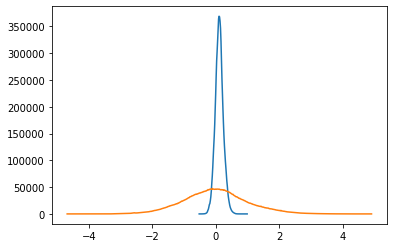

In [21]:
def draw_distribution(data, data2):
    diff = data.max() - data.min()
    diff2 = data2.max() - data2.min()    

    if diff > diff2:
        flag = True
        d1 = data2
        d2 = data
    else:
        flag = False
        d1 = data
        d2 = data2

    s1 = d1.min()
    e1 = d1.max()
    s2 = d2.min()
    e2 = d2.max()

    y = torch.histc(d1)    
    bins = len(y)
    x = torch.linspace(s1, e1, bins)
    
    bins2 = (bins * (e2 - s2) / (e1 - s1)).round().int()
    y2 = torch.histc(d2, bins=bins2)
    x2 = torch.linspace(s2, e2, bins2)

    if flag:
        plt.plot(x2.cpu().detach().numpy(), y2.cpu().detach().numpy())        
        plt.plot(x.cpu().detach().numpy(), y.cpu().detach().numpy())
    else:
        plt.plot(x.cpu().detach().numpy(), y.cpu().detach().numpy())
        plt.plot(x2.cpu().detach().numpy(), y2.cpu().detach().numpy())
    print(f'{bins}, {bins2}')
    
draw_distribution(y, y_std)
plt.savefig('temp.png')

100, 105


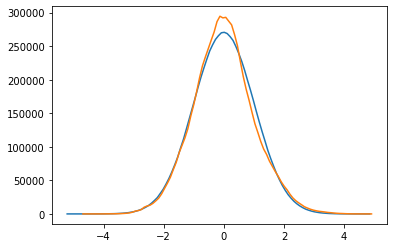

In [20]:
ll = len(y_std.view(-1))
n01 = torch.randn(ll).to(device)

draw_distribution(n01, y_std)
plt.savefig('temp.png')

In [14]:
def get_CE(symbol):
    CE = net.calc_cross_entropy(symbol)
    CE_avg = torch.log(CE).sum() / (-math.log(2) * (b * h * w))
    return CE_avg.item()

In [15]:
log_s = f",mse wt, {lambda_setting}\n"
log_s = log_s + f",yCE, {get_CE(y)}\n"
log_s = log_s + f",y_CE, {get_CE(y_std)}\n"
log_s = log_s + f",ymu, {m}\n"
log_s = log_s + f",ysigma, {s}\n"
log_s = log_s + f",y_mu, {m_}\n"
log_s = log_s + f",y_sigma, {s_}\n"
log_s = log_s + f",PSNR, {psnr}\n"
log_s = log_s + f",ms-ssim, {msssim}\n"
log_s = log_s + f",usage, {usage.item()}\n"
log_s = log_s + f",zbpp, {zbpp}\n"
log_s = log_s + f",h_mse, {F.mse_loss(gp, gp_hat)}\n"
print(log_s)

,mse wt, 0.003
,yCE, 1.4040321111679077
,y_CE, 2.048673391342163
,ymu, 0.11357956379652023
,ysigma, 0.015996074303984642
,y_mu, 5.518948631433318e-10
,y_sigma, 0.9988143444061279
,PSNR, 23.889640960123728
,ms-ssim, 0.8796447515487671
,usage, 0.49295762181282043
,zbpp, 0.042132019996643066
,h_mse, 5.206936475588009e-05



In [16]:
with open(f'{log_path}.csv','a') as f:
    f.write(log_s)

In [17]:
xx = torch.randn(18, 64, 128, 128).to(device)

In [18]:

# def standardized(y, means, scales):
#     variance = model.lower_bound_s(scales)
#     y_std = y - means    
#     y_std = y_std / variance
#     ce_N01 = model.calc_cross_entropy(y_std)
#     return y_std, ce_N01


# def direct_calc_gaussian_(y):
#     means = y.mean(1).unsqueeze(1)
#     scales = ((y - means) ** 2).mean(1).unsqueeze(1)
#     variance = torch.sqrt(scales)    
#     gaussian_params = torch.cat([variance, means], 1)    
#     z = model.h_a(gaussian_params)
#     z_hat, z_likelihoods = model.entropy_bottleneck(z)
#     gp_hat = model.h_s(z_hat)    
#     scales_hat, means_hat = gp_hat.chunk(2, 1)    
# #     print(F.mse_loss(gaussian_params, gp_hat))    
#     y_std, ce = standardized(y, means_hat, scales_hat)
    
#     print(f'{scales_hat[0, 0, 0, 0]}, {variance[0, 0, 0, 0]}')
#     print(F.mse_loss(scales_hat, variance))

#     print(f'{means_hat[0, 0, 0, 0]}, {means[0, 0, 0, 0]}')
#     print(F.mse_loss(means_hat, means))

#     print(F.mse_loss(gaussian_params, gp_hat))    
    
#     return y_std

# xx = torch.randn(18, 64, 128, 128).to(device)
# xxx = direct_calc_gaussian_(xx)
# print(xx[0, :, 0, 0])
# print(xxx[0, :, 0, 0])




